# 0. 목표

- 자전거 배치 및 운영 전략 최적화

- 자전거 대여 수요 정확히 예측

--> 대여 시스템의 효율성 증대, 사용자 만족도 증가

- RMSLE를 최대한 낮추기

# 기본 설정 및 백업


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

try:
    plt.rcParams['font.family'] = 'Apple SD Gothic Neo'
except:
    try:
        plt.rcParams['font.family'] = 'NanumGothic'
    except:
        plt.rcParams['font.family'] = 'AppleGothic'

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
fm._load_fontmanager(try_read_cache=False)


from sklearn.preprocessing import MinMaxScaler

bicycle_train = pd.read_csv("train.csv")
bicycle_test = pd.read_csv("test.csv")

bicycle_train_backup = bicycle_train.copy()
bicycle_test_backup = bicycle_test.copy()

Matplotlib is building the font cache; this may take a moment.


# 1. 데이터 파악 및 전처리


## 결측치·중복치 점검

In [2]:
bicycle_train.info()

bicycle_train.isna().sum() # 결측치 없음
bicycle_train.duplicated().sum() # 중복치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


np.int64(0)

## 오류치 점검

In [3]:
for i in bicycle_train.columns:
    print(f"[{i}]: {bicycle_train[i].unique()}") # 형식에 어긋난 데이터 없음

[datetime]: ['2011-01-01 00:00:00' '2011-01-01 01:00:00' '2011-01-01 02:00:00' ...
 '2012-12-19 21:00:00' '2012-12-19 22:00:00' '2012-12-19 23:00:00']
[season]: [1 2 3 4]
[holiday]: [0 1]
[workingday]: [0 1]
[weather]: [1 2 3 4]
[temp]: [ 9.84  9.02  8.2  13.12 15.58 14.76 17.22 18.86 18.04 16.4  13.94 12.3
 10.66  6.56  5.74  7.38  4.92 11.48  4.1   3.28  2.46 21.32 22.96 23.78
 24.6  19.68 22.14 20.5  27.06 26.24 25.42 27.88 28.7  30.34 31.16 29.52
 33.62 35.26 36.9  32.8  31.98 34.44 36.08 37.72 38.54  1.64  0.82 39.36
 41.  ]
[atemp]: [14.395 13.635 12.88  17.425 19.695 16.665 21.21  22.725 21.97  20.455
 11.365 10.605  9.85   8.335  6.82   5.305  6.06   9.09  12.12   7.575
 15.91   3.03   3.79   4.545 15.15  18.18  25.    26.515 27.275 29.545
 23.485 25.76  31.06  30.305 24.24  18.94  31.82  32.575 33.335 28.79
 34.85  35.605 37.12  40.15  41.665 40.91  39.395 34.09  28.03  36.365
 37.88  42.425 43.94  38.635  1.515  0.76   2.275 43.18  44.695 45.455]
[humidity]: [ 81  80  75  86 

### count

In [4]:
# casual + registered = count 오류치 점검
bicycle_train[bicycle_train["count"] != bicycle_train["casual"] + bicycle_train["registered"]].shape[0] 
# 0

0

### holiday, workingday

In [5]:
# 근무일이면서 공휴일(1,1) 있는지 확인
bicycle_train[(bicycle_train["holiday"] == 1) & (bicycle_train["workingday"] == 1)].shape[0] 
# 0

0

## 기타 점검

### datetime
계절성은 존재할 수 있으므로 datetime 칼럼을 연, 월, 주, 일, 시간, 요일의 범주형 데이터로 쪼개서 진행한다.

In [6]:
# 연, 월, 일, 주, 일, 시간, 요일 칼럼 추가
bicycle_train["datetime"] = pd.to_datetime(bicycle_train["datetime"])

bicycle_train["year"] = bicycle_train["datetime"].dt.year
bicycle_train["month"] = bicycle_train["datetime"].dt.month
bicycle_train["week"] = bicycle_train["datetime"].dt.isocalendar().week
bicycle_train["day"] = bicycle_train["datetime"].dt.day
bicycle_train["hour"] = bicycle_train["datetime"].dt.hour
bicycle_train["weekday"] = bicycle_train["datetime"].dt.weekday
bicycle_train = bicycle_train.drop("datetime", axis=1)

# bicycle_train.isna().sum() # 0

### 요일 - holiday

|칼럼 값|0,0|0,1|0,0|0,1|0,0|1,0|0,1|···|
|---|---|---|---|---|---|---|---|---|
|날짜|- 1/2|1/3 - 1/7|1/8 - 1/9|1/10 - 1/14|1/15 - 1/16|1/17|1/18 -|···|
|요일|- 일|월 - 금|토 - 일|월 - 금|토 - 일|월|화 - |···|

csv 파일 분석을 통해 도출한 holiday와 workingday의 결과쌍이다.((1,1) 데이터는 없음)

- (0, 1): 평일 일반

- (1, 0): 평일 공휴일

- (0, 0): 주말 일반

holiday는 1일 경우에 평일 공휴일임을 암시할 뿐, 평일/주말을 나타내지 않는다.

date_state 칼럼을 만들어 구분한다.

- 0: 평일 일반

- 1: 주말 일반

- 2: 평일 공휴일

In [7]:
bicycle_train["is_weekend"] = bicycle_train["weekday"].isin([5, 6]).astype(int)
bicycle_train["date_state"] = 0

bicycle_train.loc[(bicycle_train["is_weekend"]==0)&(bicycle_train["holiday"]!=1), "date_state"] = 0
bicycle_train.loc[(bicycle_train["is_weekend"]==1)&(bicycle_train["holiday"]!=1), "date_state"] = 1
bicycle_train.loc[bicycle_train["holiday"] == 1, "date_state"] = 2

bicycle_train = bicycle_train.drop(["is_weekend", "holiday", "workingday"], axis=1)

# bicycle_train.isna().sum() #0

# 2. 시각화

### 수치형 데이터 히트맵

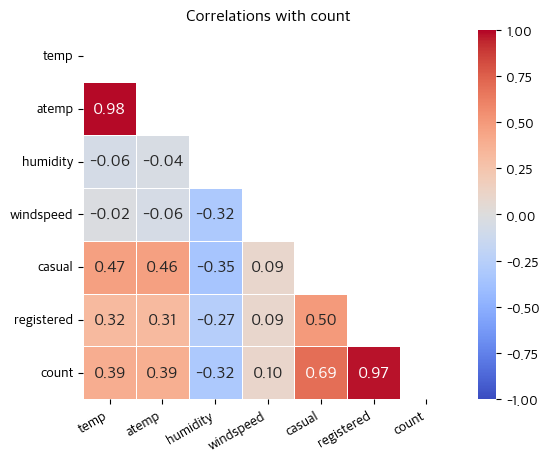

In [8]:
tmp_bicycle_train = bicycle_train.drop(["season", "weather", "year", "month", "week", "day", 
                                        "hour", "weekday", "date_state"], axis=1)

tmp_corr = tmp_bicycle_train.corr()
mask = np.triu(np.ones_like(tmp_corr, dtype=bool))

plt.figure()

sns.heatmap(
    tmp_corr,
    annot=True,
    square=True,
    fmt=".2f",
    mask=mask,
    linewidths=.5,
    vmin=-1,
    vmax=1,
    annot_kws={"size": 12},
    cmap="coolwarm",
    cbar_kws={"shrink": 1},
)

plt.xticks(rotation=30, ha="right")
plt.yticks(rotation=0)
plt.title(f"Correlations with count")

plt.show()

casual과 registered는 합해서 count가 되는 수이므로 count와 강력한 상관관계를 가질 수밖에 없다.

그 외의 요소로 temp, atemp는 0.39라는 숫자를 가지는데, 적정 온도를 벗어난 양극단의 온도의 존재로 인한 것으로 보인다.

습도는 높을수록 자전거 대여량이 줄어드는 것에 일정 수준의 의미가 있다고 해석할 수 있다.

/var/folders/h6/_8g_zbns4n53222bttvjsx_40000gn/T/ipykernel_52383/1757042098.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_bicycle_train[key] = tmp_bicycle_train[key].map(value)
/var/folders/h6/_8g_zbns4n53222bttvjsx_40000gn/T/ipykernel_52383/1757042098.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_bicycle_train[key] = tmp_bicycle_train[key].map(value)


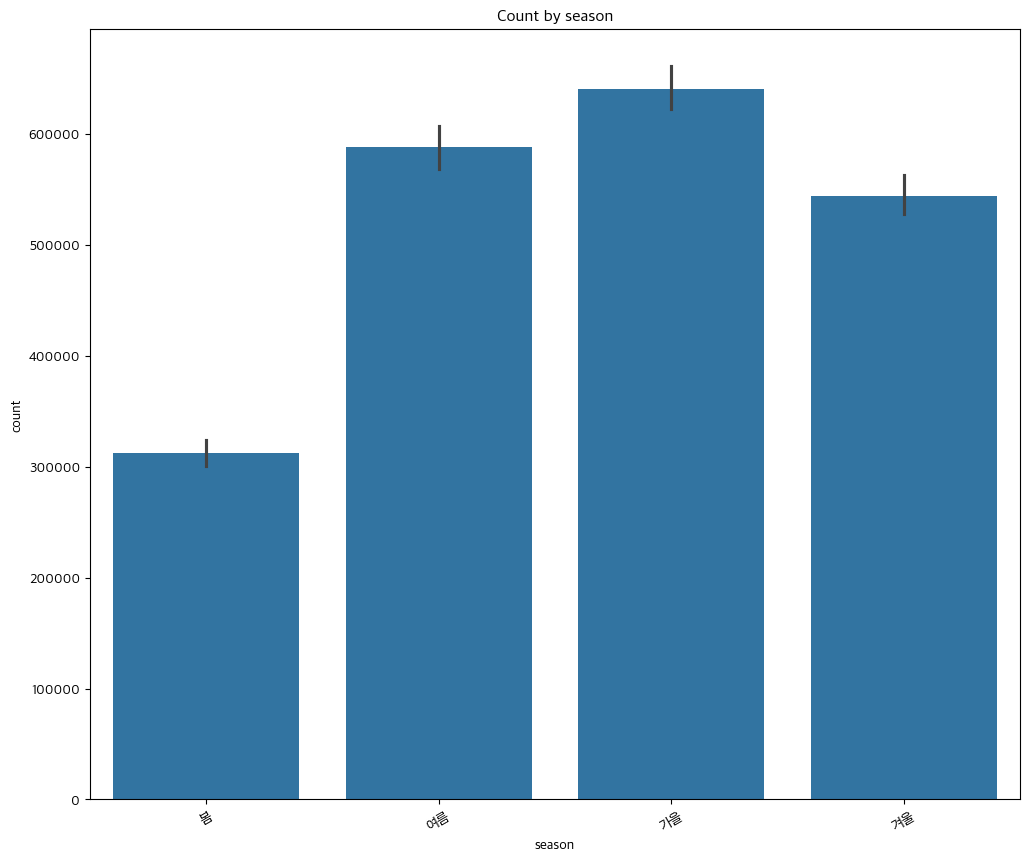

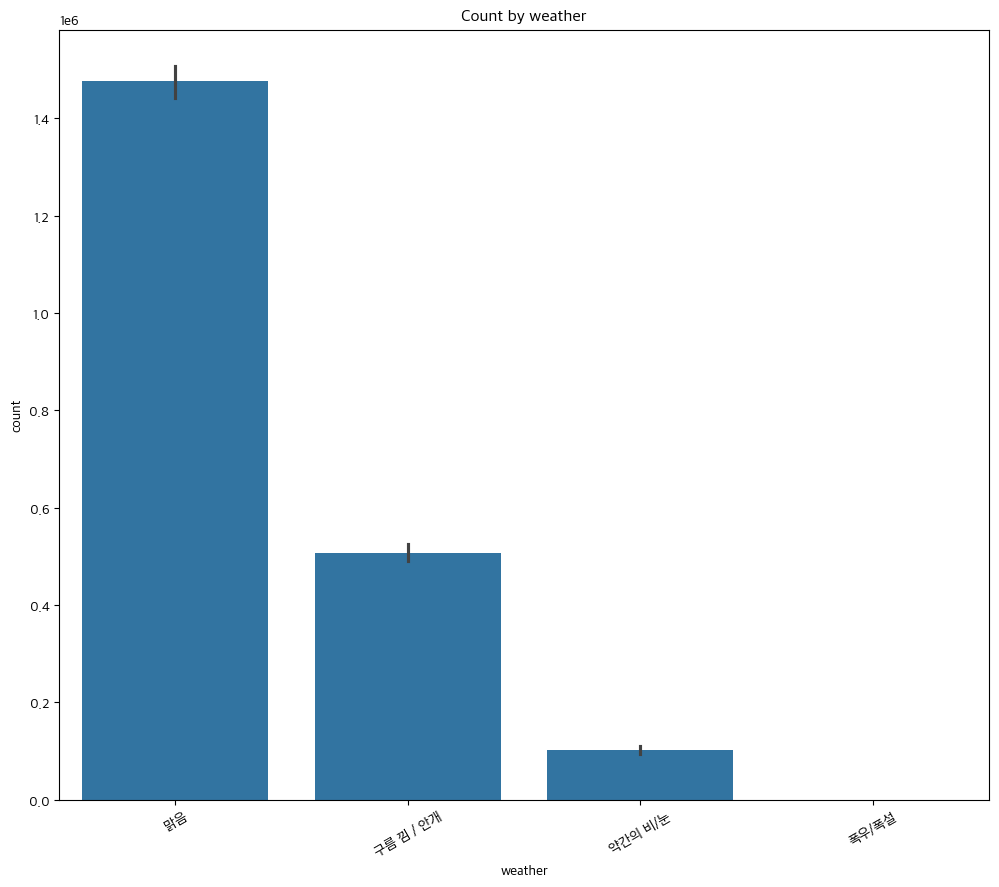

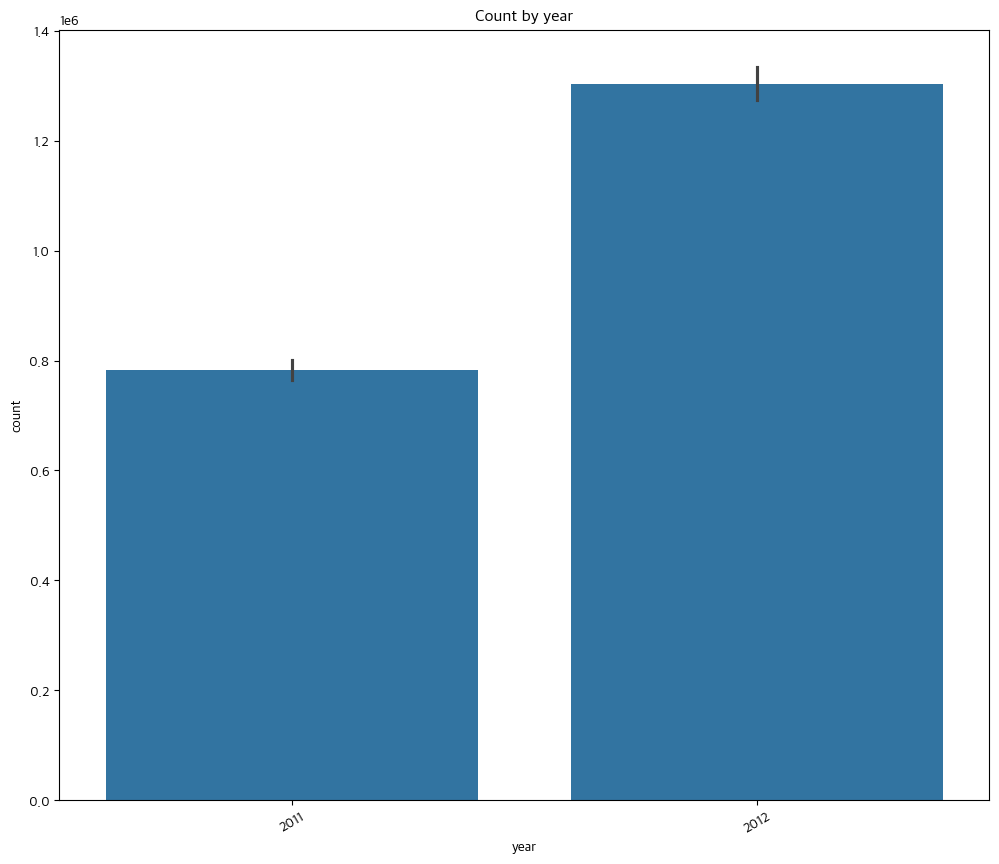

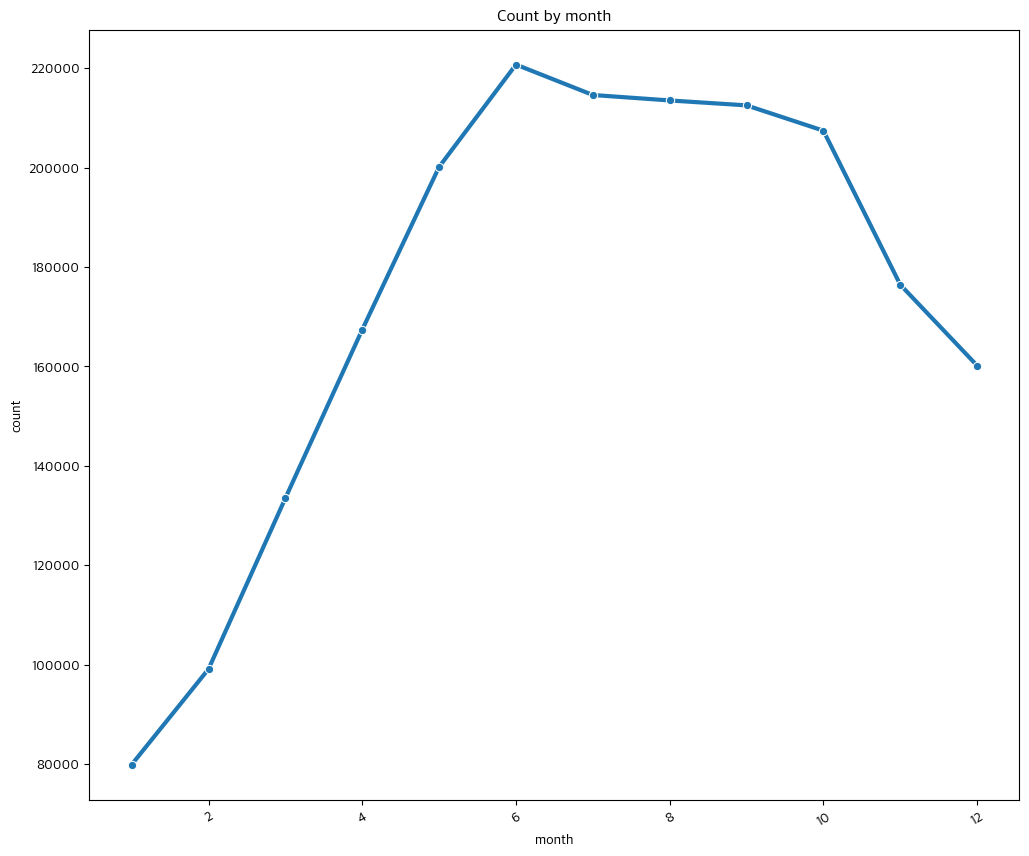

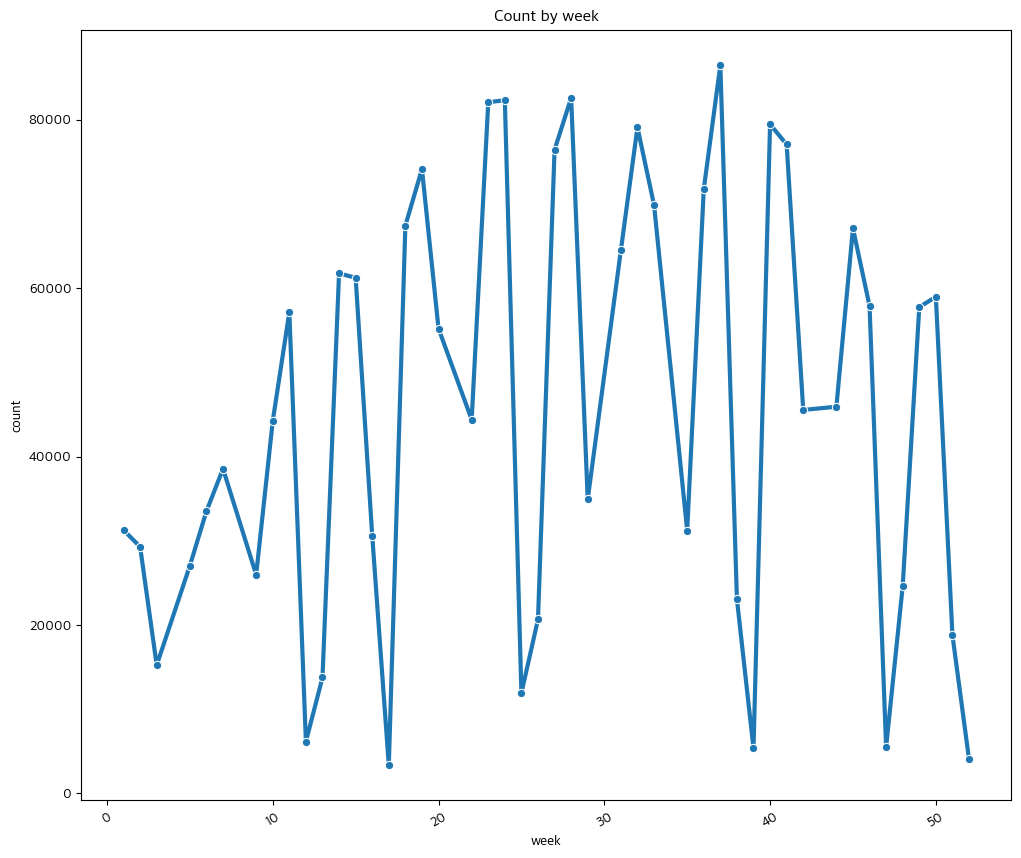

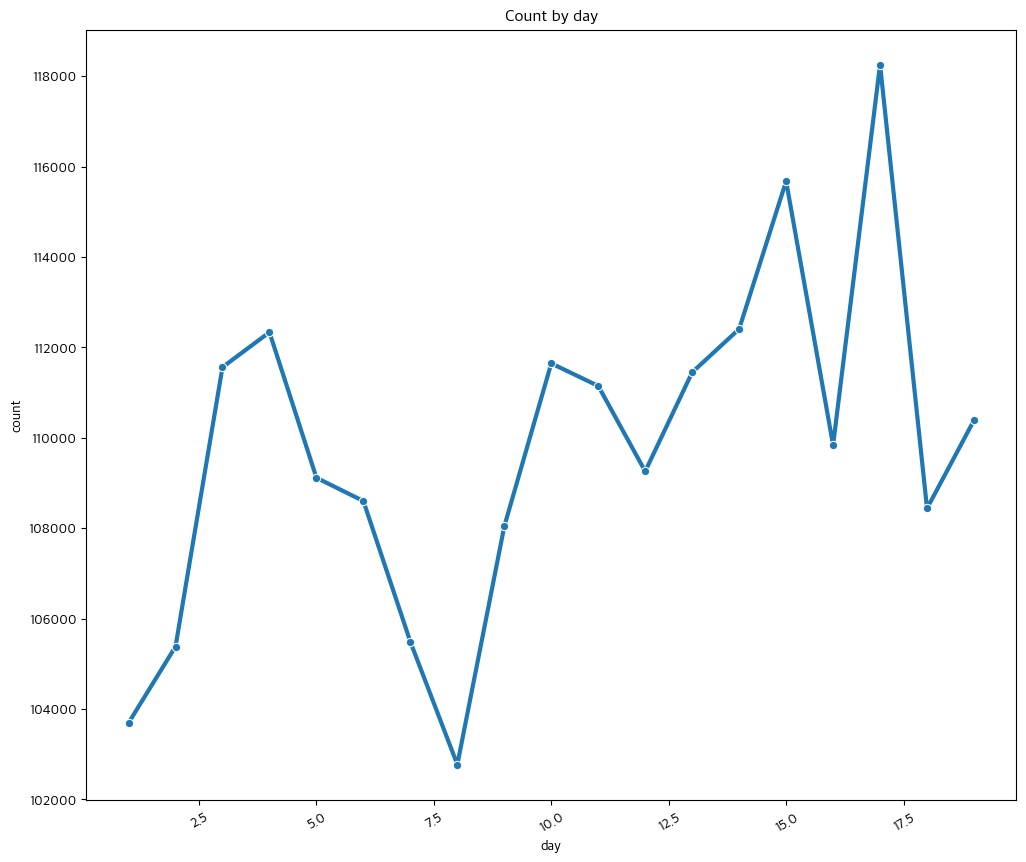

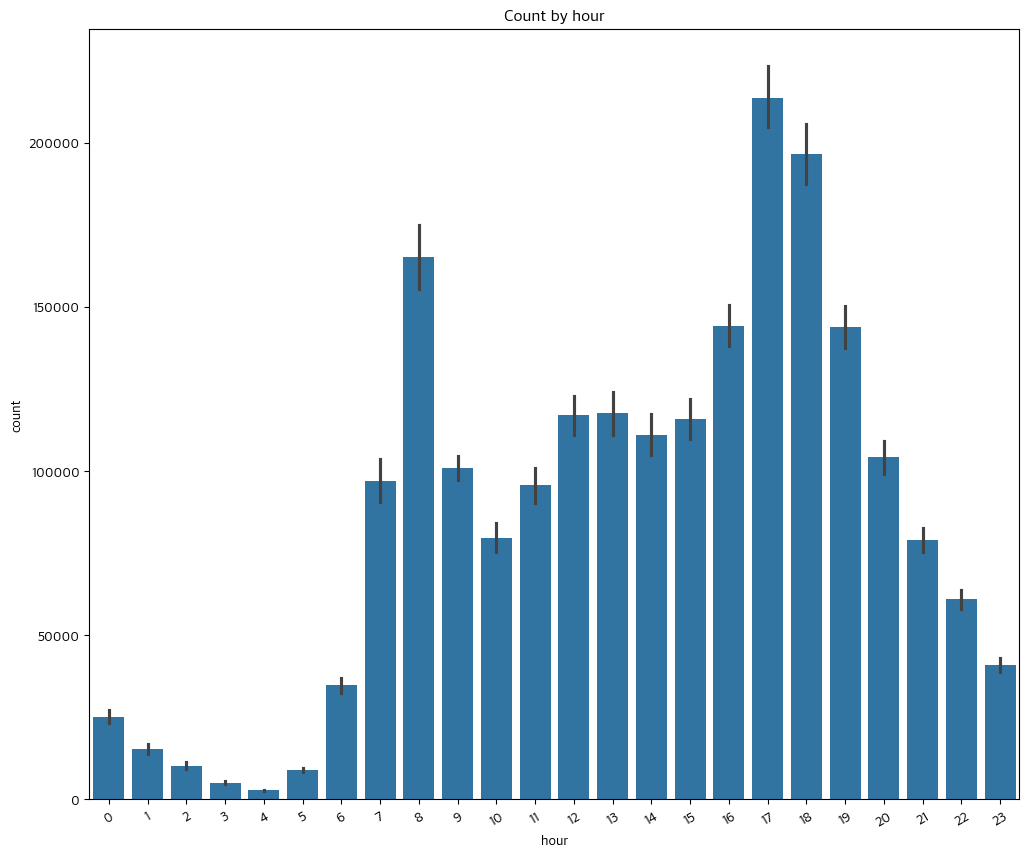

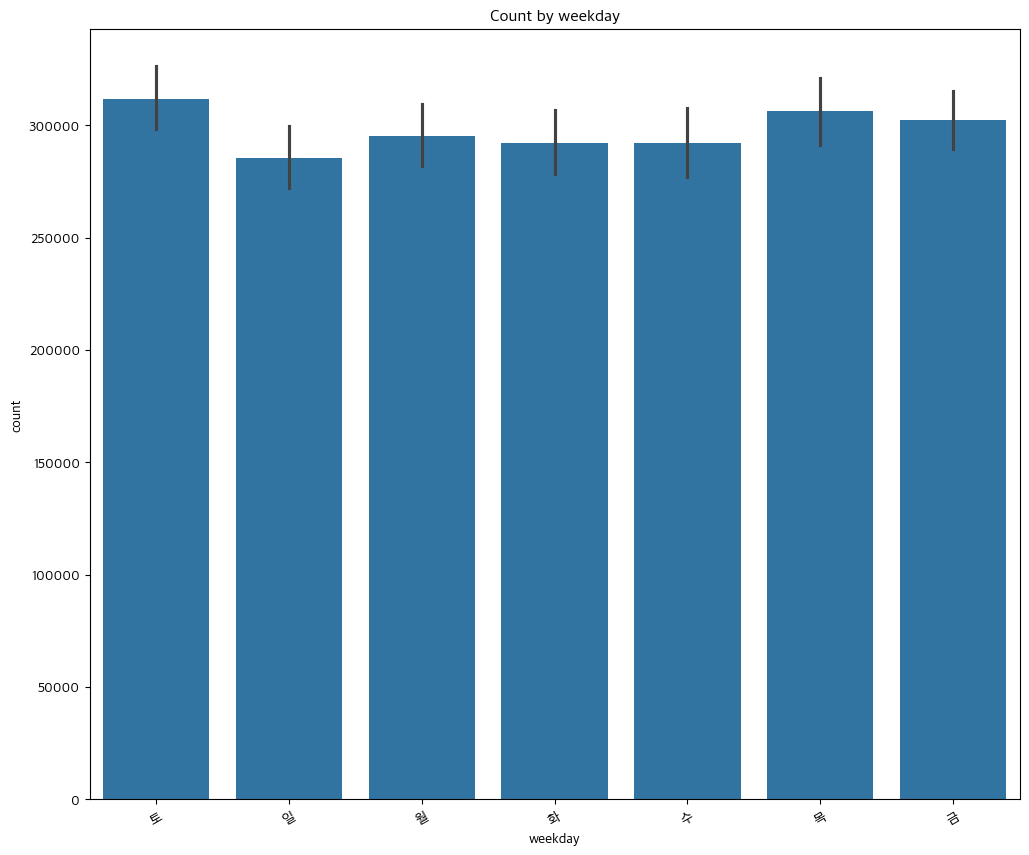

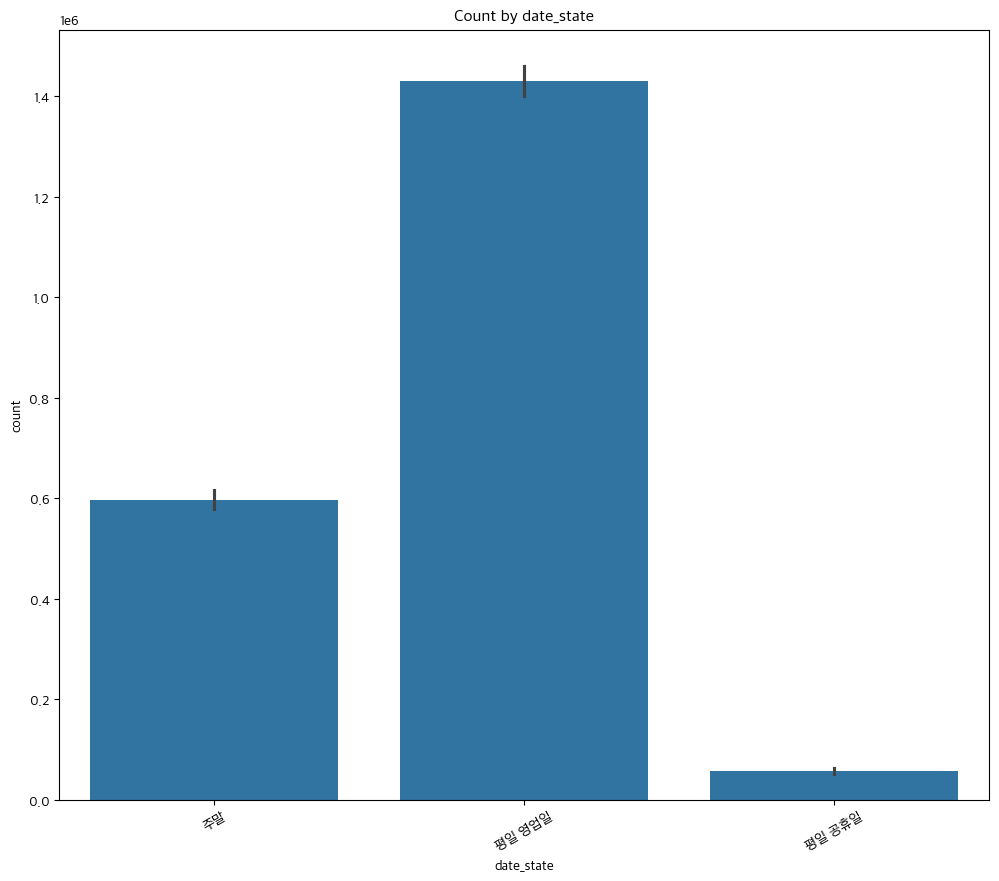

In [9]:
tmp_bicycle_train = bicycle_train[["count", "season", "weather", "year", "month", 
                                   "week", "day", "hour", "weekday", "date_state"]]

tmp_seasonal_list = ["month", "week", "day"]

tmp_map_dict = {
    "season": {1: "봄", 2: "여름", 3: "가을", 4: "겨울"},
    "weather": {1: "맑음", 2: "구름 낌 / 안개", 3: "약간의 비/눈", 4: "폭우/폭설"},
    "date_state": {0: "평일 영업일", 1: "주말", 2: "평일 공휴일"},
    "weekday": {0: "월", 1: "화", 2: "수", 3: "목", 4: "금", 5: "토", 6: "일"}
    }   

for key, value in tmp_map_dict.items():
    tmp_bicycle_train[key] = tmp_bicycle_train[key].map(value)


for i in tmp_bicycle_train.columns.drop("count"):

    plt.figure(figsize=(12,10))

    if i in tmp_seasonal_list:
        sns.lineplot(
            data=tmp_bicycle_train,
            x=i,
            y="count",
            marker="o",
            markers=True,
            linewidth=3,
            errorbar=None,
            estimator=sum
        )

    else:
        sns.barplot(
            data=tmp_bicycle_train,
            x=i, 
            y="count",
            estimator=sum
        )

    plt.xticks(rotation=30, ha="center")
    plt.yticks(rotation=0)
    plt.title(f"Count by {i}")

    plt.show()

# 3. 학습 모델 설계



## 학습 모델 선정

- 분류가 아니므로 회귀 모델을 사용해야 한다.

- 모델 4종을 비교한다.(LinearRegression, Ridge, Lasso, SVR)

- 파라미터: 각 파라미터를 비교함으로써 파라미터의 실효성을 확인한다.
    
    - Ridge, Lasso: alpha

    - SVR: C, kernel

- 교차 검증: Grid를 사용할 때와 하지 않을 때를 비교함으로써 교차검증의 실효성을 확인한다.

- 기타 사항

    - 데이터 개수가 적으므로 split_test는 진행하지 않는다.

    - 전날의 대여량이 다음날의 대여량에 영향을 미치지 않으므로, 시계열로 진행하지 않는다.



## 기본 준비

In [10]:
# test에 없는 count, registered, casual 삭제
X_train = bicycle_train.drop(["count", "registered", "casual"], axis=1)
y_train = bicycle_train["count"]

# 범주형 데이터 원핫인코딩
tmp_category_list = X_train.columns.drop(["temp", "atemp", "humidity", "windspeed"])
X_train = pd.get_dummies(X_train, columns=tmp_category_list)

# 정규화 전 X 백업
X_train_before_scaling = X_train.copy()

# X 정규화
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

# y 로그화
y_train = np.log(y_train)

# 백업
X_train_backup = X_train.copy()
y_train_backup = y_train.copy()

# 손실함수(RMSLE)
def get_loss(y, y_, convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

# 결과 데이터프레임
result_df = pd.DataFrame(columns=["Model", "RMSLE", "Param", "CV"])

## 회귀 모델 O / 하이퍼 파라미터 X / 교차 검증 X

In [11]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR

tmp_model_list = [LinearRegression(), Lasso(), Ridge(), SVR()]

for i in tmp_model_list:
    model = i
    model_name = str(model).split("(")[0]

    model.fit(X_train, y_train)
    result = model.predict(X_train)
    loss = get_loss(y_train, result, True)

    result_df.loc[len(result_df)] = [model_name, loss, "None", "None"]

result_df.sort_values("RMSLE")

,Model,RMSLE,Param,CV
3,SVR,0.230716,None,None
0,LinearRegression,0.572218,None,None
2,Ridge,0.573574,None,None
1,Lasso,1.419671,None,None


## 회귀 모델 O / 하이퍼 파라미터 O / 교차 검증 X

In [12]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR

tmp_param_list = [0.1, 1, 10]

for alpha in tmp_param_list:
    model = Lasso(alpha=alpha)
    model_name = str(model).split("(")[0]
    
    model.fit(X_train, y_train)

    result = model.predict(X_train)
    loss = get_loss(y_train, result, True)

    result_df.loc[len(result_df)] = [model_name, loss, f"alpha: {alpha}", "None"]


for alpha in tmp_param_list:
    model = Ridge(alpha=alpha)
    model_name = str(model).split("(")[0]
    
    model.fit(X_train, y_train)

    result = model.predict(X_train)
    loss = get_loss(y_train, result, True)

    result_df.loc[len(result_df)] = [model_name, loss, f"alpha: {alpha}", "None"]


tmp_c_list = [0.1, 1, 10]
tmp_kernel_list = ["linear", "rbf"]

for c in tmp_c_list:
    for kernel in tmp_kernel_list:
        model = SVR(C=c, kernel=kernel)
        model_name = str(model).split("(")[0]
        
        model.fit(X_train, y_train)
        result = model.predict(X_train)
        loss = get_loss(y_train, result, True)

        result_df.loc[len(result_df)] = [model_name, loss, f"c: {c}, kernel: {kernel}", "None"]


result_df.sort_values("RMSLE")

,Model,RMSLE,Param,CV
15,SVR,0.109788,"c: 10, kernel: rbf",None
3,SVR,0.230716,None,None
13,SVR,0.230716,"c: 1, kernel: rbf",None
11,SVR,0.535330,"c: 0.1, kernel: rbf",None
0,LinearRegression,0.572218,None,None
7,Ridge,0.572619,alpha: 0.1,None
2,Ridge,0.573574,None,None
8,Ridge,0.573574,alpha: 1,None
9,Ridge,0.574080,alpha: 10,None
10,SVR,0.606267,"c: 0.1, kernel: linear",None


## 회귀 모델 O / 하이퍼 파라미터 X / 교차 검증 O

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# LinearRegression은 
# model = LinearRegression()
# model_name = str(model).split("(")[0]

# param_grid = {}
# grid = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_log_error')

# grid.fit(X_train, y_train)

# result_df.loc[len(result_df)] = [model_name, -grid.best_score_, "None", "Grid"]



model = SVR()
model_name = str(model).split("(")[0]

param_grid = {}
grid = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_log_error')

grid.fit(X_train, y_train)

result_df.loc[len(result_df)] = [model_name, -grid.best_score_, "None", "Grid"]



model = Ridge()
model_name = str(model).split("(")[0]

param_grid = {}
grid = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_log_error')

grid.fit(X_train, y_train)

result_df.loc[len(result_df)] = [model_name, -grid.best_score_, "None", "Grid"]



model = Lasso()
model_name = str(model).split("(")[0]

param_grid = {}
grid = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_log_error')

grid.fit(X_train, y_train)

result_df.loc[len(result_df)] = [model_name, -grid.best_score_, "None", "Grid"]


result_df.sort_values("RMSLE")

,Model,RMSLE,Param,CV
15,SVR,0.109788,"c: 10, kernel: rbf",None
16,SVR,0.134674,None,Grid
17,Ridge,0.174173,None,Grid
3,SVR,0.230716,None,None
13,SVR,0.230716,"c: 1, kernel: rbf",None
18,Lasso,0.358426,None,Grid
11,SVR,0.535330,"c: 0.1, kernel: rbf",None
0,LinearRegression,0.572218,None,None
7,Ridge,0.572619,alpha: 0.1,None
8,Ridge,0.573574,alpha: 1,None


## 회귀 모델 O / 하이퍼 파라미터 O / 교차 검증 O

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

model = SVR()
model_name = str(model).split("(")[0]

param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_log_error')

grid.fit(X_train, y_train)

result_df.loc[len(result_df)] = [model_name, -grid.best_score_, grid.best_params_, "Grid"]



param_grid = {'C': [0.1, 1, 10]}
grid = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_log_error')

grid.fit(X_train, y_train)

result_df.loc[len(result_df)] = [model_name, -grid.best_score_, grid.best_params_, "Grid"]



param_grid = {'kernel': ['linear', 'rbf']}
grid = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_log_error')

grid.fit(X_train, y_train)

result_df.loc[len(result_df)] = [model_name, -grid.best_score_, grid.best_params_, "Grid"]




model = Ridge()
model_name = str(model).split("(")[0]

param_grid = {'alpha': [0.1, 1, 10]}
grid = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_log_error')

grid.fit(X_train, y_train)

result_df.loc[len(result_df)] = [model_name, -grid.best_score_, grid.best_params_, "Grid"]




model = Lasso()
model_name = str(model).split("(")[0]

param_grid = {'alpha': [0.1, 1, 10]}
grid = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_log_error')

grid.fit(X_train, y_train)

result_df.loc[len(result_df)] = [model_name, -grid.best_score_, grid.best_params_, "Grid"]

## 실험 결과 분석

### 실험 결과 표

In [15]:
result_df["Param"] = result_df["Param"].astype(str).str.strip("{}")
result_df.sort_values("RMSLE")

,Model,RMSLE,Param,CV
15,SVR,0.109788,"c: 10, kernel: rbf",None
20,SVR,0.125626,'C': 10,Grid
19,SVR,0.125626,"'C': 10, 'kernel': 'rbf'",Grid
21,SVR,0.134674,'kernel': 'rbf',Grid
16,SVR,0.134674,None,Grid
17,Ridge,0.174173,None,Grid
22,Ridge,0.174173,'alpha': 1,Grid
3,SVR,0.230716,None,None
13,SVR,0.230716,"c: 1, kernel: rbf",None
23,Lasso,0.347113,'alpha': 0.1,Grid


RMSLE가 가장 낮은 모델은 교차 검증 없이 진행한 SVR 모델로, 파라미터는 C: 10, kernel: rbf이다.

이 다음으로 RMSLE가 낮았던 함수는 1위 조합에서 GridCV만 추가된 조합으로,

교차 검증이 언제나 좋은 결과로 이끌어주는 것은 아니라는 결론이 나온다.




In [16]:
# result_df["Param_C"] = result_df["Param"].apply(lambda x: result_df["Param"].str.split(",").str[0])
result_df["Param_kernel"] = result_df["Param"].str.split(",").str[1].str.split(":").str[1].str.strip("").str.strip("""''""")
result_df["Param_tmp"] = result_df["Param"].str.split(",").str[0]

result_df["Param_C"] = result_df["Param_tmp"].str.split("c:").str[1].str.strip(" ").str.strip("""''""")
result_df["Param_alpha"] = result_df["Param_tmp"].str.split("alpha:").str[1].str.strip(" ").str.strip("""''""")

result_df.loc[19, "Param_C"] = 10
result_df.loc[19, "Param_kernel"] = "rbf"
result_df.loc[20, "Param_C"] = 10
result_df.loc[21, "Param_kernel"] = "rbf"
result_df.loc[22, "Param_alpha"] = 1
result_df.loc[23, "Param_alpha"] = 0.1

result_df = result_df.drop(["Param", "Param_tmp"], axis=1)

result_df = result_df.fillna(str(None))
result_df["Param_kernel"] = result_df["Param_kernel"].str.strip(" ")

df = result_df.copy()

In [17]:
df.sort_values("RMSLE")

,Model,RMSLE,CV,Param_kernel,Param_C,Param_alpha
15,SVR,0.109788,None,rbf,10,None
20,SVR,0.125626,Grid,None,10,None
19,SVR,0.125626,Grid,rbf,10,None
21,SVR,0.134674,Grid,rbf,None,None
16,SVR,0.134674,Grid,None,None,None
17,Ridge,0.174173,Grid,None,None,None
22,Ridge,0.174173,Grid,None,None,1
3,SVR,0.230716,None,None,None,None
13,SVR,0.230716,None,rbf,1,None
23,Lasso,0.347113,Grid,None,None,0.1


모델 성능 실험에서 1위는 SVR 모델로, 0.109788의 RSMLE 수치를 보인다.

하이퍼 파라미터는 C: 10, kernel: rbf이며, 교차 검증을 실시하지 않았을 때이다.


### 기본 모델 비교

/var/folders/h6/_8g_zbns4n53222bttvjsx_40000gn/T/ipykernel_52383/1016331595.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  tmp = sns.barplot(data=data, x="Model", y="RMSLE", palette="Set2")


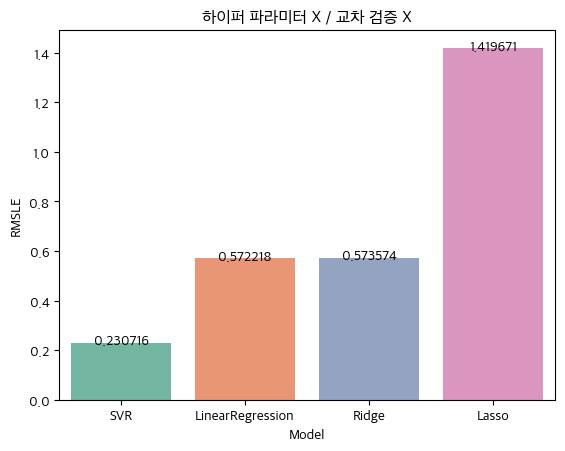

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
df["Param_kernel"] = df["Param_kernel"].str.strip(" ")
df = result_df.copy()

data = df[(df["CV"]=="None")&(df["Param_kernel"]=="None")&(df["Param_C"]=="None")&(df["Param_alpha"]=="None")].sort_values("RMSLE")
tmp = sns.barplot(data=data, x="Model", y="RMSLE", palette="Set2")
plt.title("하이퍼 파라미터 X / 교차 검증 X")
for container in tmp.containers:
    tmp.bar_label(container, fmt="%f", label_type="edge", padding=-3)

SVR의 성능이 가장 우수하며, Lasso 모델의 성능이 가장 낮다.

Lasso 모델에 입히는 하이퍼 파라미터와 교차 검증을 통해 격차를 극복할 수 있을지 관찰할 수 있다.

### C, kernel 성능 비교

SVR 모델의 하이퍼 파라미터로 C (0.1, 1, 10)와 kernel(linear, rbf)의 모든 경우의 수를 살펴보았다.

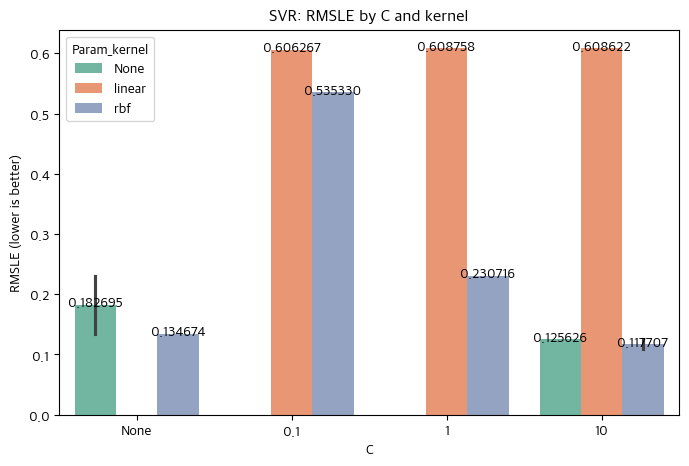

In [19]:
df["Param_kernel"] = df["Param_kernel"].str.strip(" ")
df_svr = df[df["Model"] == "SVR"].copy()

plt.figure(figsize=(8,5))
tmp = sns.barplot(
    data=df_svr[df_svr["Param_C"].notna()],
    x="Param_C",
    y="RMSLE",
    hue="Param_kernel",
    palette="Set2"
)

plt.title("SVR: RMSLE by C and kernel")
plt.ylabel("RMSLE (lower is better)")
plt.xlabel("C")
for container in tmp.containers:
    tmp.bar_label(container, fmt="%f", label_type="edge", padding=-3)
plt.show()


SVR 모델의 전반적인 성능은 커널이 rbf일 때 더욱 우수했다.

linear 커널은 선형, rbf 커널은 비선형 데이터를 다루는 차이에서 기인한 것으로 보인다.

### alpha 성능 비교

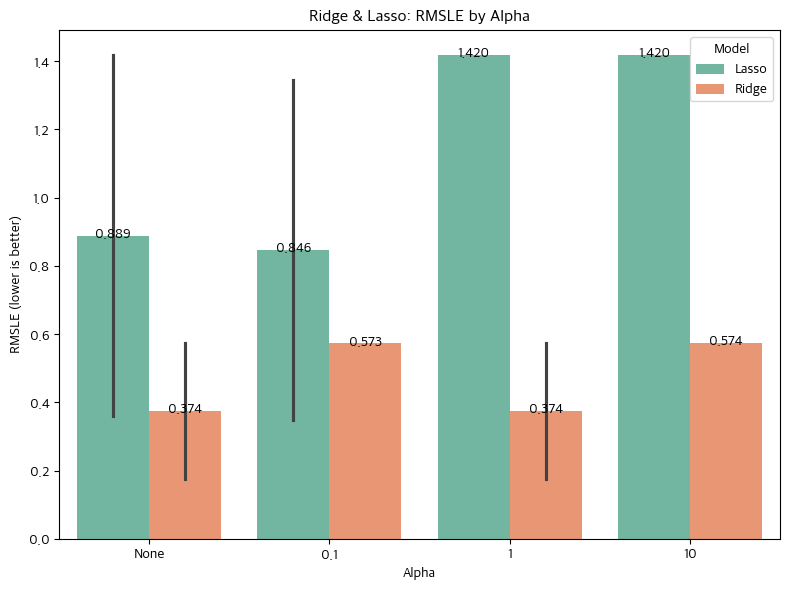

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ridge, Lasso만 필터링
df_rl = df[df["Model"].isin(["Ridge", "Lasso"])].copy()
df_rl = df_rl[df_rl["Param_alpha"].notna()]  # alpha값 존재하는 행만

plt.figure(figsize=(8, 6))

# barplot
sns.barplot(
    data=df_rl,
    x="Param_alpha",
    y="RMSLE",
    hue="Model",
    palette="Set2"
)

ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", label_type="edge", padding=-3)

plt.title("Ridge & Lasso: RMSLE by Alpha")
plt.xlabel("Alpha")
plt.ylabel("RMSLE (lower is better)")
plt.tight_layout()
plt.show()

현 데이터에서는 alpha의 값이 높지 않을 때 성능이 더 높은 것으로 도출된다.

Lasso 모델에서는 alpha를 0.1, Ridge에서는 없애거나 1로 잡는 것이 바람직하다.

### C, kernel

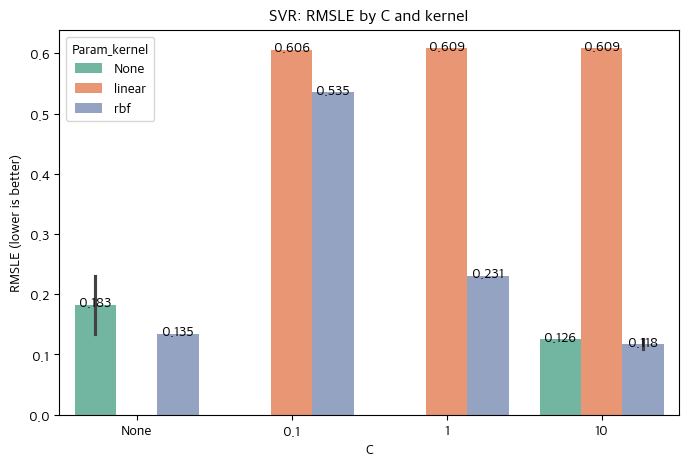

In [21]:
df_svr = df[df["Model"] == "SVR"].copy()

plt.figure(figsize=(8,5))
sns.barplot(
    data=df_svr[df_svr["Param_C"].notna()],
    x="Param_C",
    y="RMSLE",
    hue="Param_kernel",
    palette="Set2"
)
plt.title("SVR: RMSLE by C and kernel")
plt.ylabel("RMSLE (lower is better)")
plt.xlabel("C")
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", label_type="edge", padding=-3)


plt.show()

### 교차 검증 성능

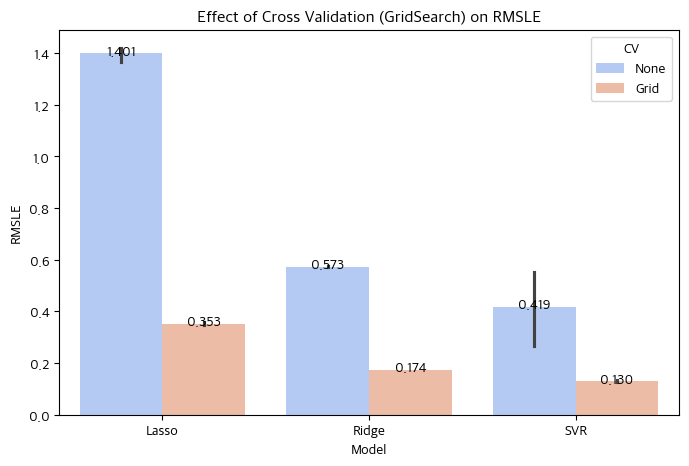

In [22]:
df = result_df.copy()

plt.figure(figsize=(8,5))
sns.barplot(
    data=df[df["Model"].isin(["SVR", "Ridge", "Lasso"])],
    x="Model",
    y="RMSLE",
    hue="CV",
    palette="coolwarm",
)
plt.title("Effect of Cross Validation (GridSearch) on RMSLE")
plt.ylabel("RMSLE")
plt.xlabel("Model")

ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", label_type="edge", padding=-3)

plt.show()

교차 검증이 전반적으로 모델의 성능을 높여주는 것으로 보이나,

본 실험에서의 1위 성능은 교차 검증을 하지 않은 모델이었다.

즉, 교차 검증이 언제나 좋은 방향으로 가지는 않는다는 것을 이번 실험을 통해 알 수 있다.

또한, Grid 이용 과정에서, 시간도 머신러닝에서 중요한 리소스라는 것을 체감할 수 있었다.

### 실험 결론

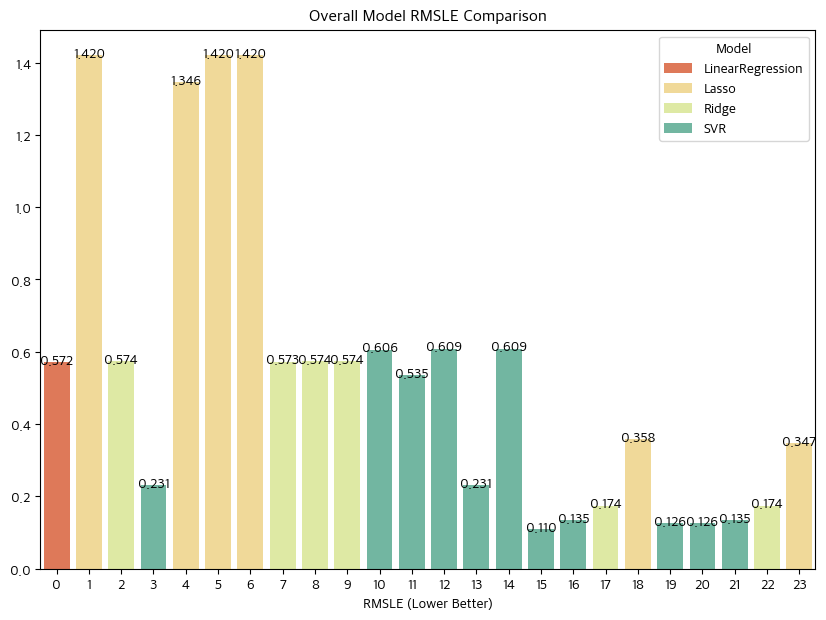

In [23]:
df_sorted = df.sort_values("Model").reset_index()

plt.figure(figsize=(10,7))
sns.barplot(
    data=df_sorted,
    x="index",
    y="RMSLE",
    hue="Model",
    dodge=False,
    palette="Spectral"    
)
plt.title("Overall Model RMSLE Comparison")
plt.xlabel("RMSLE (Lower Better)")
plt.ylabel("")

ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", label_type="edge", padding=-3)

plt.show()

모델, 하이퍼 파라미터, 교차 검증에 정답은 없으며,

각 데이터에 알맞는 모델을 적절히 설계할 수 있는 능력의 중요성을 익힐 수 있는 실험이었다.

또한, 시간이라는 요소도 머신러닝의 중요한 리소스라는 점을 통감할 수 있었다.


파라미터 측면 또한 파라미터가 전혀 없을 때보다도 성능이 좋지 않은 결과물도 볼 수 있다.

파라미터 조절 역량에 대한 중요성을 절감할 수 있었다.

# 결론

교차 검증 없이 파라미터만을 부여한 SVR 모델이 RMSLE가 가장 낮았지만,

그만큼 소요하는 시간이 길어 코드 수정 혹은 반복되는 실험에 부담이 크다.

현재는 데이터 처리 등의 작성을 마친 상태이므로 비교적 부담이 덜하여 이 모델로 선택할 수 있다.

만약 코드 수정 사항이 많이 남아 있는 상태라면 SVR의 차선책으로 Ridge 모델을 1 알파로 설정 후 사용하는 게 바람직하다는 판단이다.

In [24]:
# 최종 코드

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

bicycle_train = pd.read_csv("train.csv")
bicycle_test = pd.read_csv("test.csv")

bicycle_train_backup = bicycle_train.copy()
bicycle_test_backup = bicycle_test.copy()

# 연, 월, 일, 주, 일, 시간, 요일 칼럼 추가
bicycle_train["datetime"] = pd.to_datetime(bicycle_train["datetime"])

bicycle_train["year"] = bicycle_train["datetime"].dt.year
bicycle_train["month"] = bicycle_train["datetime"].dt.month
bicycle_train["week"] = bicycle_train["datetime"].dt.isocalendar().week
bicycle_train["day"] = bicycle_train["datetime"].dt.day
bicycle_train["hour"] = bicycle_train["datetime"].dt.hour
bicycle_train["weekday"] = bicycle_train["datetime"].dt.weekday
bicycle_train = bicycle_train.drop("datetime", axis=1)


bicycle_train["is_weekend"] = bicycle_train["weekday"].isin([5, 6]).astype(int)
bicycle_train["date_state"] = 0

bicycle_train.loc[(bicycle_train["is_weekend"]==0)&(bicycle_train["holiday"]!=1), "date_state"] = 0
bicycle_train.loc[(bicycle_train["is_weekend"]==1)&(bicycle_train["holiday"]!=1), "date_state"] = 1
bicycle_train.loc[bicycle_train["holiday"] == 1, "date_state"] = 2

bicycle_train = bicycle_train.drop(["is_weekend", "holiday", "workingday"], axis=1)


# test에 없는 count, registered, casual 삭제
X_train = bicycle_train.drop(["count", "registered", "casual"], axis=1)
y_train = bicycle_train["count"]

# 범주형 데이터 원핫인코딩
tmp_category_list = X_train.columns.drop(["temp", "atemp", "humidity", "windspeed"])
X_train = pd.get_dummies(X_train, columns=tmp_category_list)

# 정규화 전 X 백업
X_train_before_scaling = X_train.copy()

# X 정규화
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

# y 로그화
y_train = np.log(y_train)

model = SVR(C=10, kernel='rbf')

model.fit(X_train, y_train)



bicycle_test = pd.read_csv("test.csv")
bicycle_test_backup = bicycle_test.copy()

# 연, 월, 일, 주, 일, 시간, 요일 칼럼 추가
bicycle_test["datetime"] = pd.to_datetime(bicycle_test["datetime"])

bicycle_test["year"] = bicycle_test["datetime"].dt.year
bicycle_test["month"] = bicycle_test["datetime"].dt.month
bicycle_test["week"] = bicycle_test["datetime"].dt.isocalendar().week
bicycle_test["day"] = bicycle_test["datetime"].dt.day
bicycle_test["hour"] = bicycle_test["datetime"].dt.hour
bicycle_test["weekday"] = bicycle_test["datetime"].dt.weekday
bicycle_test = bicycle_test.drop("datetime", axis=1)

bicycle_test["is_weekend"] = bicycle_test["weekday"].isin([5, 6]).astype(int)
bicycle_test["date_state"] = 0

bicycle_test.loc[(bicycle_test["is_weekend"]==0)&(bicycle_test["holiday"]!=1), "date_state"] = 0
bicycle_test.loc[(bicycle_test["is_weekend"]==1)&(bicycle_test["holiday"]!=1), "date_state"] = 1
bicycle_test.loc[bicycle_test["holiday"] == 1, "date_state"] = 2

bicycle_test = bicycle_test.drop(["is_weekend", "holiday", "workingday"], axis=1)

X_test = bicycle_test.copy()

# 범주형 데이터 원핫인코딩
tmp_category_list = X_test.columns.drop(["temp", "atemp", "humidity", "windspeed"])
X_test = pd.get_dummies(X_test, columns=tmp_category_list)

X_test = X_test.reindex(columns=X_train_before_scaling.columns, fill_value=0)
X_test = scaler.transform(X_test)

y_pred = model.predict(X_test)

y_pred = np.exp(y_pred)
print(y_pred)
submission = bicycle_test_backup["datetime"].copy()



submission = pd.DataFrame({"datetime": bicycle_test_backup["datetime"],
                           "count": y_pred})
submission.to_csv("submission.csv", index=False)
print("saved")
print(submission.head())

print(submission[submission["count"] < 0].shape[0])

[  7.26192545   3.49854058   1.85222361 ... 143.96739398  81.02794385
  45.70264479]
saved
              datetime     count
0  2011-01-20 00:00:00  7.261925
1  2011-01-20 01:00:00  3.498541
2  2011-01-20 02:00:00  1.852224
3  2011-01-20 03:00:00  1.784893
4  2011-01-20 04:00:00  1.008554
0
